# Billboard Chart Performance Analysis: How Music Trends Have Evolved (1958-2021)


## Executive Summary

This is an analysis on the over 327,000 song entries on the Billboard charts across six decades to examine:

1. How have songs been performing on the charts now, in the past, and what are their overall trends?
2. Who are the dominating performers of each decade and overall?

This analysis reveals how in the new age of social media, streaming platforms, and algorithmic discovery, the path to musical success has been changed and transformed.


## Data Card

**Dataset:** Top 100 Billboard

**Source:**
Kaggle - Sujay Kapadnis, 2023
https://www.kaggle.com/datasets/sujaykapadnis/top-100-billboard?select=Hot+Stuff.csv

**Time Period:** August 1958 - May 2021

**Size:**

- 327,895 chart entries (billboard.csv)
- 29,383 unique songs with audio features (audio_features.csv)

**Fields:**

_billboard.csv_
| Field | Type | Description |
|-------|------|-------------|
| url | character | Billboard Chart URL |
| week_id | character | Date of chart week |
| week_position | integer | Position on chart (1-100) |
| song | character | Song name |
| performer | character | Performer/artist name |
| song_id | character | Unique song identifier |
| instance | integer | Chart run instance number |
| previous_week_position | integer | Position previous week |
| peak_position | integer | Best position achieved |
| weeks_on_chart | integer | Cumulative weeks on chart |

_audio_features.csv_
| Field | Type | Description |
|-------|------|-------------|
| spotify_genre | character | Genre classification |
| danceability | float | Danceability score (0.0-1.0) |
| energy | float | Energy level (0.0-1.0) |
| valence | float | Musical positiveness (0.0-1.0) |
| tempo | float | Beats per minute (BPM) |
| loudness | float | Loudness in decibels (dB) |
| acousticness | float | Acoustic confidence (0.0-1.0) |
| instrumentalness | float | Vocal presence (0.0-1.0) |
| liveness | float | Live performance likelihood (0.0-1.0) |
| speechiness | float | Spoken word presence (0.0-1.0) |
| spotify_track_popularity | integer | Spotify popularity score |

**Limitations:**

- Almost, but not all, Billboard songs have correlating Spotify audio features
  - 29,389 unique songs in Billboard dataset
  - 29,383 songs with Spotify audio features
  - 99.83% match rate
- Spotify features are calculated algorithmically and may not capture subjective musical qualities
- Starting and ending decades lack entries
  - 50s contains just August 1958-
  - 20s contains just January 2020-May 2021
- Billboard's ranking factors have changed over time (sales, radio, streaming weights)

**License:**

- Dataset: Billboard "The Hot 100" and Spotify Audio Features
- Source: Data.World
- Original sources:
  - Billboard.com (chart data)
  - Spotify Web API (audio features)
- Compiled by: Sean Miller
- License: Data.World operates under various open data licenses; Billboard chart positions are factual data (not copyrightable); Spotify audio features accessed via public API

**Attribution:**

- Sujay Kapadnis (Kaggle uploader)
- Sean Miller (Data.World compilation)
- Billboard.com (historical chart data)
- Spotify (audio feature calculations via Web API)


## Loading and File IO


In [4]:
# 🚀 Importing libraries
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set consistent visualization style
sns.set_style("whitegrid")
sns.set_palette("Set2")

# Get Set2 colors for specific use
SET2_COLORS = sns.color_palette("Set2")
COLORS = {
    'color1': SET2_COLORS[0],       # Teal
    'color2': SET2_COLORS[1],       # Orange
    'color3': SET2_COLORS[2],       # Green
    'color4': SET2_COLORS[3],       # Red
    'before_2010': SET2_COLORS[0],  # Teal
    'after_2010': SET2_COLORS[1],   # Orange
    'line_dark1': '#5E8A8A',        # Darker teal for lines
    'line_dark2': '#CC6600',        # Darker orange for lines
}

# For Plotly charts
PLOTLY_SET2 = px.colors.qualitative.Set2

print("✓ Libraries imported successfully")
print("✓ Visualization settings configured")

✓ Libraries imported successfully
✓ Visualization settings configured


In [5]:
# Define data paths
DATA_DIR = Path('data')
BILLBOARD_FILE = DATA_DIR / 'billboard.csv'
AUDIO_FEATURES_FILE = DATA_DIR / 'audio_features.csv'


def load_csv(path: Path) -> pd.DataFrame:
  """
  Load a CSV file with robust error handling.

  Parameters
  ----------
  path : Path
      Path to the CSV file

  Returns
  -------
  pd.DataFrame
      Loaded dataframe

  Raises
  ------
  FileNotFoundError
      If file doesn't exist at specified path
  ValueError
      If file cannot be parsed as CSV
  """
  try:
    df = pd.read_csv(path)
  except FileNotFoundError as e:
    raise FileNotFoundError(
        f"Could not find {path.name}. Check that the file exists in the data/ folder."
    ) from e
  except pd.errors.ParserError as e:
    raise ValueError(
        f"Parsing failed for {path.name}. Check delimiter or bad rows."
    ) from e
  else:
    print(f"✓ Successfully loaded {path.name}")
    print(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    return df


# Load datasets with error handling
print("="*60)
print("LOADING DATA")
print("="*60)

billboard = load_csv(BILLBOARD_FILE)
audio_features = load_csv(AUDIO_FEATURES_FILE)

print("\n" + "="*60)
print("DATA LOADING SUMMARY")
print("="*60)
print(f"Billboard chart entries: {len(billboard):,}")
print(f"Unique songs in Billboard: {billboard['song_id'].nunique():,}")
print(f"Songs with audio features: {len(audio_features):,}")
print(
    f"Match rate: {len(audio_features) / billboard['song_id'].nunique() * 100:.1f}%")

LOADING DATA
✓ Successfully loaded billboard.csv
  Shape: 327,895 rows × 10 columns
✓ Successfully loaded audio_features.csv
  Shape: 29,503 rows × 22 columns

DATA LOADING SUMMARY
Billboard chart entries: 327,895
Unique songs in Billboard: 29,389
Songs with audio features: 29,503
Match rate: 100.4%


In [6]:
# Display dataset information
print("\n" + "="*60)
print("BILLBOARD DATASET STRUCTURE")
print("="*60)
print(f"\nColumns ({len(billboard.columns)}):")
print(billboard.columns.tolist())
print("\nData types:")
print(billboard.dtypes)
print("\nFirst 3 rows:")
print(billboard.head(3))

print("\n" + "="*60)
print("AUDIO FEATURES DATASET STRUCTURE")
print("="*60)
print(f"\nColumns ({len(audio_features.columns)}):")
print(audio_features.columns.tolist())
print("\nData types:")
print(audio_features.dtypes)
print("\nFirst 3 rows:")
print(audio_features.head(3))


BILLBOARD DATASET STRUCTURE

Columns (10):
['url', 'week_id', 'week_position', 'song', 'performer', 'song_id', 'instance', 'previous_week_position', 'peak_position', 'weeks_on_chart']

Data types:
url                        object
week_id                    object
week_position               int64
song                       object
performer                  object
song_id                    object
instance                    int64
previous_week_position    float64
peak_position               int64
weeks_on_chart              int64
dtype: object

First 3 rows:
                                                 url    week_id  \
0  http://www.billboard.com/charts/hot-100/1965-0...  7/17/1965   
1  http://www.billboard.com/charts/hot-100/1965-0...  7/24/1965   
2  http://www.billboard.com/charts/hot-100/1965-0...  7/31/1965   

   week_position                    song   performer  \
0             34  Don't Just Stand There  Patty Duke   
1             22  Don't Just Stand There  Patty Duke

## Exploratory Data Analysis (EDA)


### 1. Context

As we explore this dataset it is important to have context on what the charts are and how they work. Billboard has maintained a list of the most popular selling/streamed songs each week since they came out with the "Hot 100" list in August 1958. As time has progressed, technology and our modes and habits of listening to music have changed. Because of this the method of which Billboard tracks the "Hot" songs have molded with the times as well.


#### Distribution of Total Weeks on Chart Across All Songs

This graph shows that [Y] number of songs have maintained their spot on the Hot 100 list for [X] amount of weeks, out of all the existing song data. The histogram is the perfect visualization, as it is meant to record the numerical occurence of a certain set of data.

As the graph shows, there are thousands of songs that are able to get their name on the list for at least a couple months, but maintaining it past about 20 weeks (5 months) is where the number significantly drops off. Songs that are able to get past this point are outliers and true chart toppers, as they are clearly able to break the typical lifecycle of a popular song.

So for reference moving forward with this dataset and its patterns, here are typical song performance stats:
_Weeks on Charts_

- Median: 10.0 weeks
- Average: 11.2 weeks

As for variation, the middle 50% stay between 5.0 weeks and 16.0 weeks, with a standard deviation of 8.3 weeks.


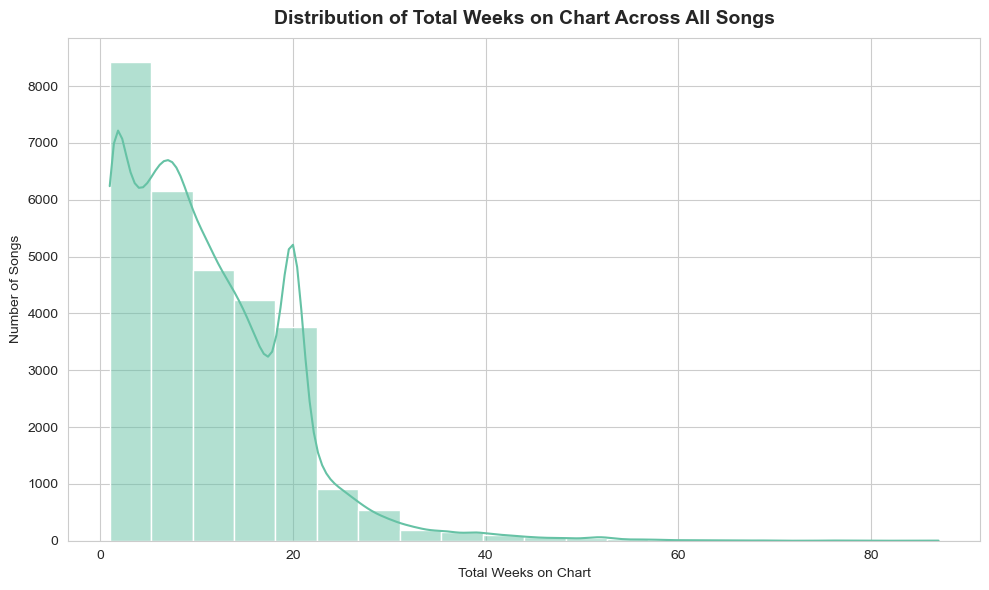

In [7]:
total_weeks = billboard.groupby(
    'song_id')['weeks_on_chart'].max().reset_index()
total_weeks.columns = ['song_id', 'total_weeks_on_chart']

# Figure
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=total_weeks,
             x='total_weeks_on_chart',
             bins=20,
             kde=True,
             ax=ax)

# Labels
ax.set_xlabel('Total Weeks on Chart')
ax.set_ylabel('Number of Songs')
ax.set_title('Distribution of Total Weeks on Chart Across All Songs',
             fontsize=14, fontweight='bold', pad=10)

# Display
plt.tight_layout()
plt.show()

### 2. Evolution of Music Trends Overtime

In this section we examine the charting patterns of songs as well as musical attributes and how they each have changed overtime.


#### Distribution of Chart Duration by Decade

This box plot shows the number of weeks Hot 100 songs from each decade charted for. The box plot shows the saturation of songs at each quartile interval to show how balanced the distribution of _weeks on chart_ for those songs is.

Because the 1950s and 2020s decades have limited data (1-2 years), the plots look more skewed than the rest. The rest of the data however, shows a notable change in typical chart longevity.

The median weeks on chart slowly rises overtime until the 2010s, so songs are typically staying longer on the charts than popular songs before. The box and whiskers also get taller and longer with more and more outliers outside the plots. So the variation and predicability of the average is song may be harder to pinpoint about current/more recent songs since they follow less a tight pattern than before.

With the advent of social media and streaming platforms it is reasonable to consider that it has opened up the door for more quick hits that chart for less time as well as created a space for songs to stay alive for longer. A quality song that sticks around is harder to achieve, and as pictured in the chart, there is a heavier saturation to songs that chart for less time now as these viral hits are easier to spread and burn just as quickly.


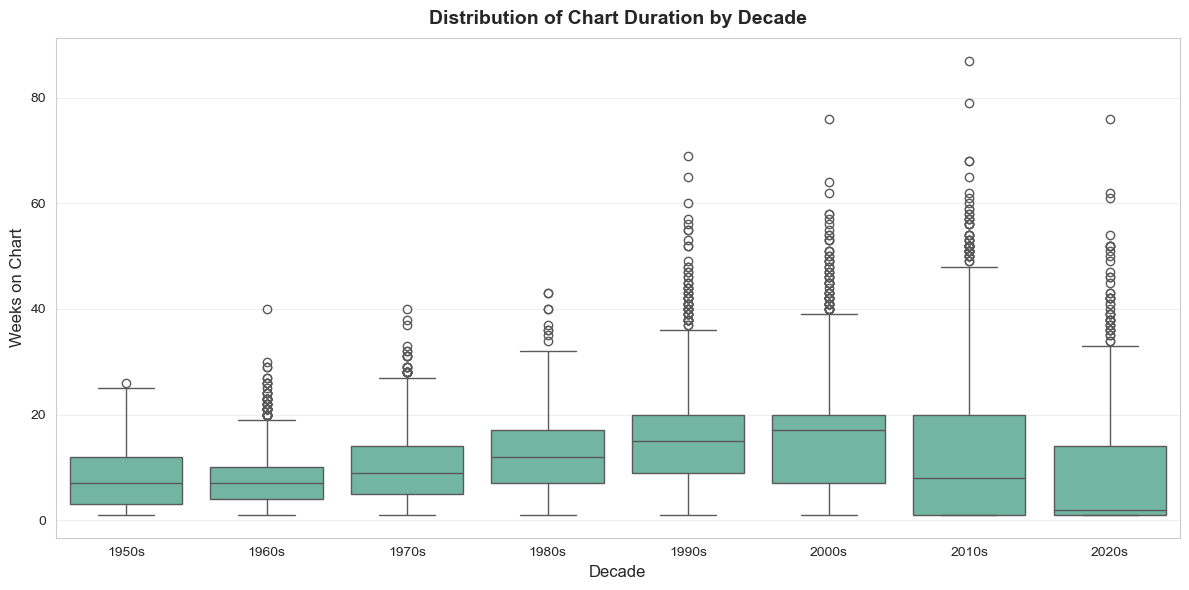

In [8]:
# Prepare data
chart_duration = billboard.copy()
chart_duration['year'] = pd.to_datetime(chart_duration['week_id']).dt.year
chart_duration['decade'] = (chart_duration['year'] // 10) * 10
chart_duration['decade_label'] = chart_duration['decade'].astype(str) + 's'

song_duration_by_decade = chart_duration.groupby(['song_id', 'decade_label']).agg({
    'weeks_on_chart': 'max',
    'song': 'first',
    'performer': 'first'
}).reset_index()

decade_order = sorted(song_duration_by_decade['decade_label'].unique())

# Figure
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=song_duration_by_decade,
            x='decade_label',
            y='weeks_on_chart',
            order=decade_order,
            ax=ax)

# Labels
ax.set_xlabel('Decade', fontsize=12)
ax.set_ylabel('Weeks on Chart', fontsize=12)
ax.set_title('Distribution of Chart Duration by Decade',
             fontsize=14, fontweight='bold', pad=10)
ax.grid(axis='y', alpha=0.3)

# Display
plt.tight_layout()
plt.show()

#### Proportion of "Climber" Songs Over Time

The line graph pictured above shows the percentage of songs from each year that climbed from at least 15 positions below their peak. The line graph is an easy, clear way to display the trend of this data chronologically through time.

Until the early 2000s, the majority of songs charting (~60-75%) were "climbers" (entering low and working their way up). This percentage has significantly plummeted all the way to under 30% starting in the late 2010s. These changes reflect the graph trends from the box and whisker plot just before this, enforcing the idea of how online habits have changed the way songs typically achieve success in this recent modern era. Songs do not typically slow burn their way up to the top, and instead quick virality has become the new method of reaching the charts with the climber percentage being as low as under 20% in 2020.

Notably the climber decline is steepest around 2008-2012, which coincides with the rise of streaming platforms like Spotify which launched in 2008. This is also when social media and smartphones were on the rise, changing the way that people both discovered and listened to music. Music used to spread more by word-of-mouth, but new technology allowed for much quicker sharing and ease of access to music. Now when a song starts to spread it moves significantly quicker and can fall off just the same.


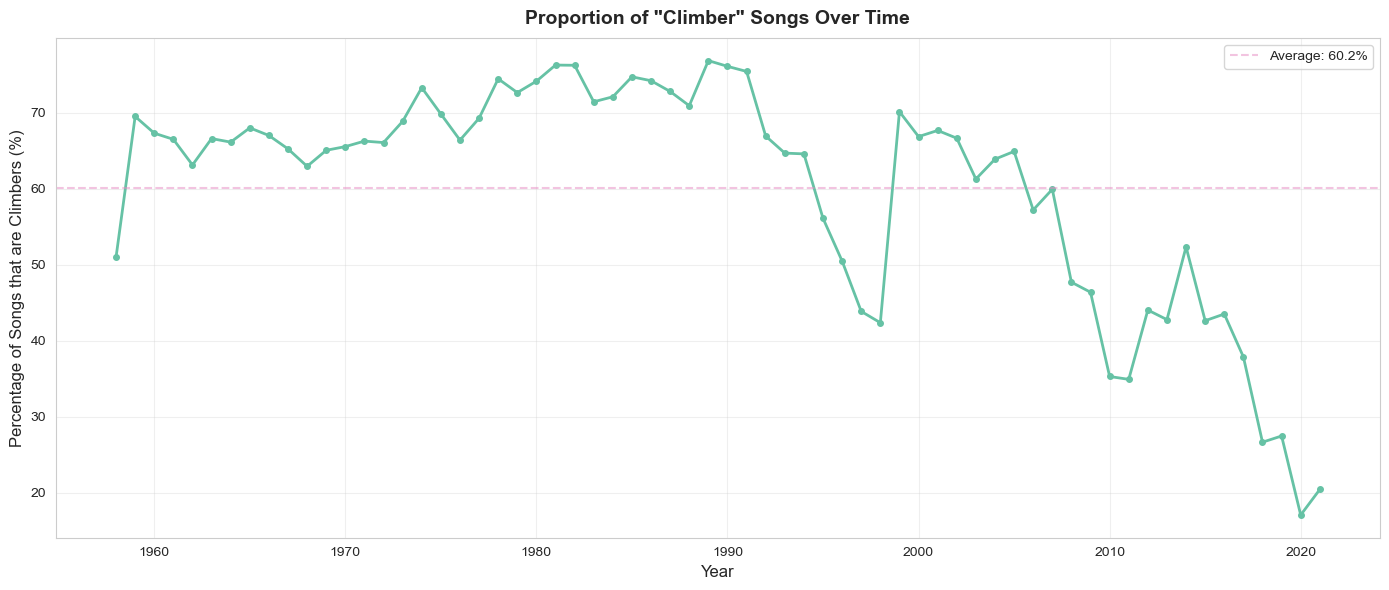

Average percentage of climbers: 60.2%
Highest year: 1989 (76.9%)
Lowest year: 2020 (17.1%)


In [9]:
# Prepare data
song_entry = billboard.groupby('song_id').agg({
    'week_position': 'first',  # First position (entry position)
    'peak_position': 'min',     # Best position achieved
    'week_id': 'first'          # Get first week_id for year
}).reset_index()

song_entry['year'] = pd.to_datetime(song_entry['week_id']).dt.year

song_entry['is_climber'] = song_entry['week_position'] > song_entry['peak_position'] + 15

climber_proportion = song_entry.groupby('year').agg({
    'is_climber': ['sum', 'count']
}).reset_index()
climber_proportion.columns = ['year', 'num_climbers', 'total_songs']
climber_proportion['pct_climbers'] = (
    climber_proportion['num_climbers'] / climber_proportion['total_songs']) * 100

# Figure
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(climber_proportion['year'],
        climber_proportion['pct_climbers'],
        marker='o',
        linewidth=2,
        markersize=4,
        color=COLORS['color1'])

mean_pct = climber_proportion['pct_climbers'].mean()
ax.axhline(y=mean_pct, color=COLORS['color4'], linestyle='--',
           alpha=0.5, label=f'Average: {mean_pct:.1f}%')
ax.legend()

# Labels
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Percentage of Songs that are Climbers (%)', fontsize=12)
ax.set_title('Proportion of "Climber" Songs Over Time',
             fontsize=14, fontweight='bold', pad=10)
ax.grid(True, alpha=0.3)

# Display
plt.tight_layout()
plt.show()

# Print summary stats
print(f"Average percentage of climbers: {mean_pct:.1f}%")
print(
    f"Highest year: {climber_proportion.loc[climber_proportion['pct_climbers'].idxmax(), 'year']:.0f} ({climber_proportion['pct_climbers'].max():.1f}%)")
print(
    f"Lowest year: {climber_proportion.loc[climber_proportion['pct_climbers'].idxmin(), 'year']:.0f} ({climber_proportion['pct_climbers'].min():.1f}%)")

#### Song Duration Over Time

As mentioned in the prior chart, the line graph is a clean and clear way to see the trend of changes overtime, exposing the rise-peak-fall pattern across six decades. This line graph shows the average song duration [Y] from each year overtime.

Average Hot 100 song runtimes slowly increased from under 2.5 minutes until its peak in the 90s at over 4.5 minutes long, almost doubling. Since then, songs have been returning to shorter times around 3.2 minutes in 2021.

**Three Distinct Eras:**

- **1958-1990s:** Steady lengthening as artists experimented with longer formats, elaborate arrangements, and extended instrumentation. Rock ballads, progressive rock, and disco contributed to this growth.
- **1990s Peak:** The CD era enabled longer tracks without vinyl constraints. Artists maximized album length and creative freedom.
- **2000s-Present:** Rapid shortening driven by streaming economics (songs played for just 30 seconds count toward plays encouraing quantity over length), playlist culture and its algorithms valuing song completion rate, viral songs favoring quick hooks, and overall shrinking attention spans in the social media age.

Today's 3.2-minute average reflects optimization for streaming algorithms and TikTok virality. Songs front-load hooks, skip long intros, and prioritize replay value over epic storytelling. Song length isn't just an artistic choice, it reflects technology constraints (vinyl/CD), business models (streaming payouts), and consumption patterns (passive listening vs. active engagement). The dramatic post-2010 decline parallels the "climber songs" trend, both driven by platform economics.


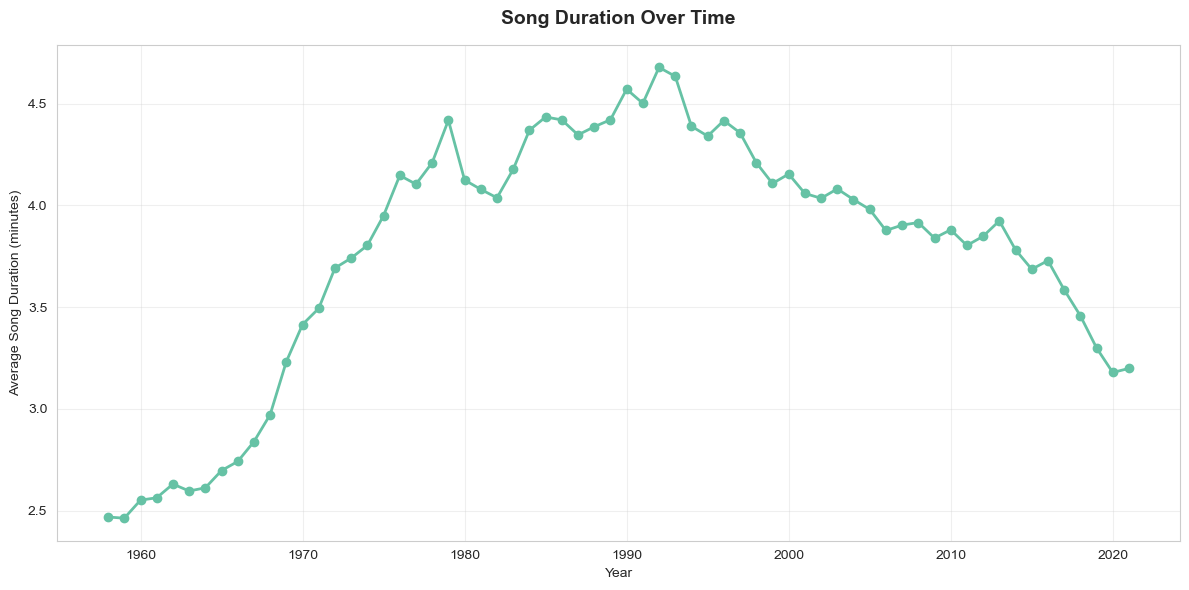

In [10]:
# Prepare data
song_data_time = billboard.merge(audio_features, on='song_id', how='inner')

song_data_time['year'] = pd.to_datetime(song_data_time['week_id']).dt.year
song_data_time['duration_minutes'] = song_data_time['spotify_track_duration_ms'] / 60000

yearly_duration = song_data_time.groupby(['year', 'song_id'])[
    'duration_minutes'].first().reset_index()
yearly_avg = yearly_duration.groupby(
    'year')['duration_minutes'].mean().reset_index()

# Figure
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(yearly_avg['year'], yearly_avg['duration_minutes'],
        marker='o', linewidth=2)

# Labels
ax.set_xlabel('Year')
ax.set_ylabel('Average Song Duration (minutes)')
ax.set_title('Song Duration Over Time', fontsize=14, fontweight='bold', pad=15)

# Display
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3. What Makes a Hit?

Examine what factors historically correlate with chart toppers.


#### Before 2010 vs 2010+: Spotify Attributes vs. Peak Position

The side-by-side scatter plots are an effective means of showing the correlation, or lack thereof, of song performance and varying song attributes (determined by Spotify). The trend lines can show if a Spotify audio attribute has any correlation with the success of a song.

All six audio features show extremely weak correlations with peak chart position in both eras (all |r| < 0.06). There is no single musical characteristic that predicts whether a song will reach #1 or languish at #100.

- **Danceability** shows the strongest relationship (though still weak), with slightly negative correlation in both eras - more danceable songs _might_ peak marginally better.
- **Loudness** increased in the 2010+ era (orange points cluster higher on the dB scale), confirming the "loudness war" trend, but louder ≠ more successful.
- **Energy, Valence, Tempo, Acousticness:** Essentially flat trend lines (r ≈ 0) in both periods - these don't predict chart position at all.

Correlations remained weak across eras - the streaming revolution didn't create a clearer audio "formula". If anything, the scatter became MORE dispersed in 2010+, suggesting even greater unpredictability. The regression lines barely differ between eras, showing consistency in this non-relationship.

Chart success depends on factors beyond measurable audio characteristics like marketing budgets, artist reputation, cultural timing, viral moments, playlist placement, and the intangible "hit quality" that algorithms can't capture. Songs with identical energy/danceability scores have wildly different chart outcomes.


Correlation Comparison - Before 2010 vs 2010+:
Feature         Before 2010     2010+           Change    
------------------------------------------------------------
energy           0.002          -0.012          -0.014
danceability    -0.056          -0.065          -0.009
valence         -0.012          -0.054          -0.042
tempo           -0.002           0.019          +0.021
loudness        -0.011          -0.042          -0.031
acousticness     0.037           0.043          +0.006


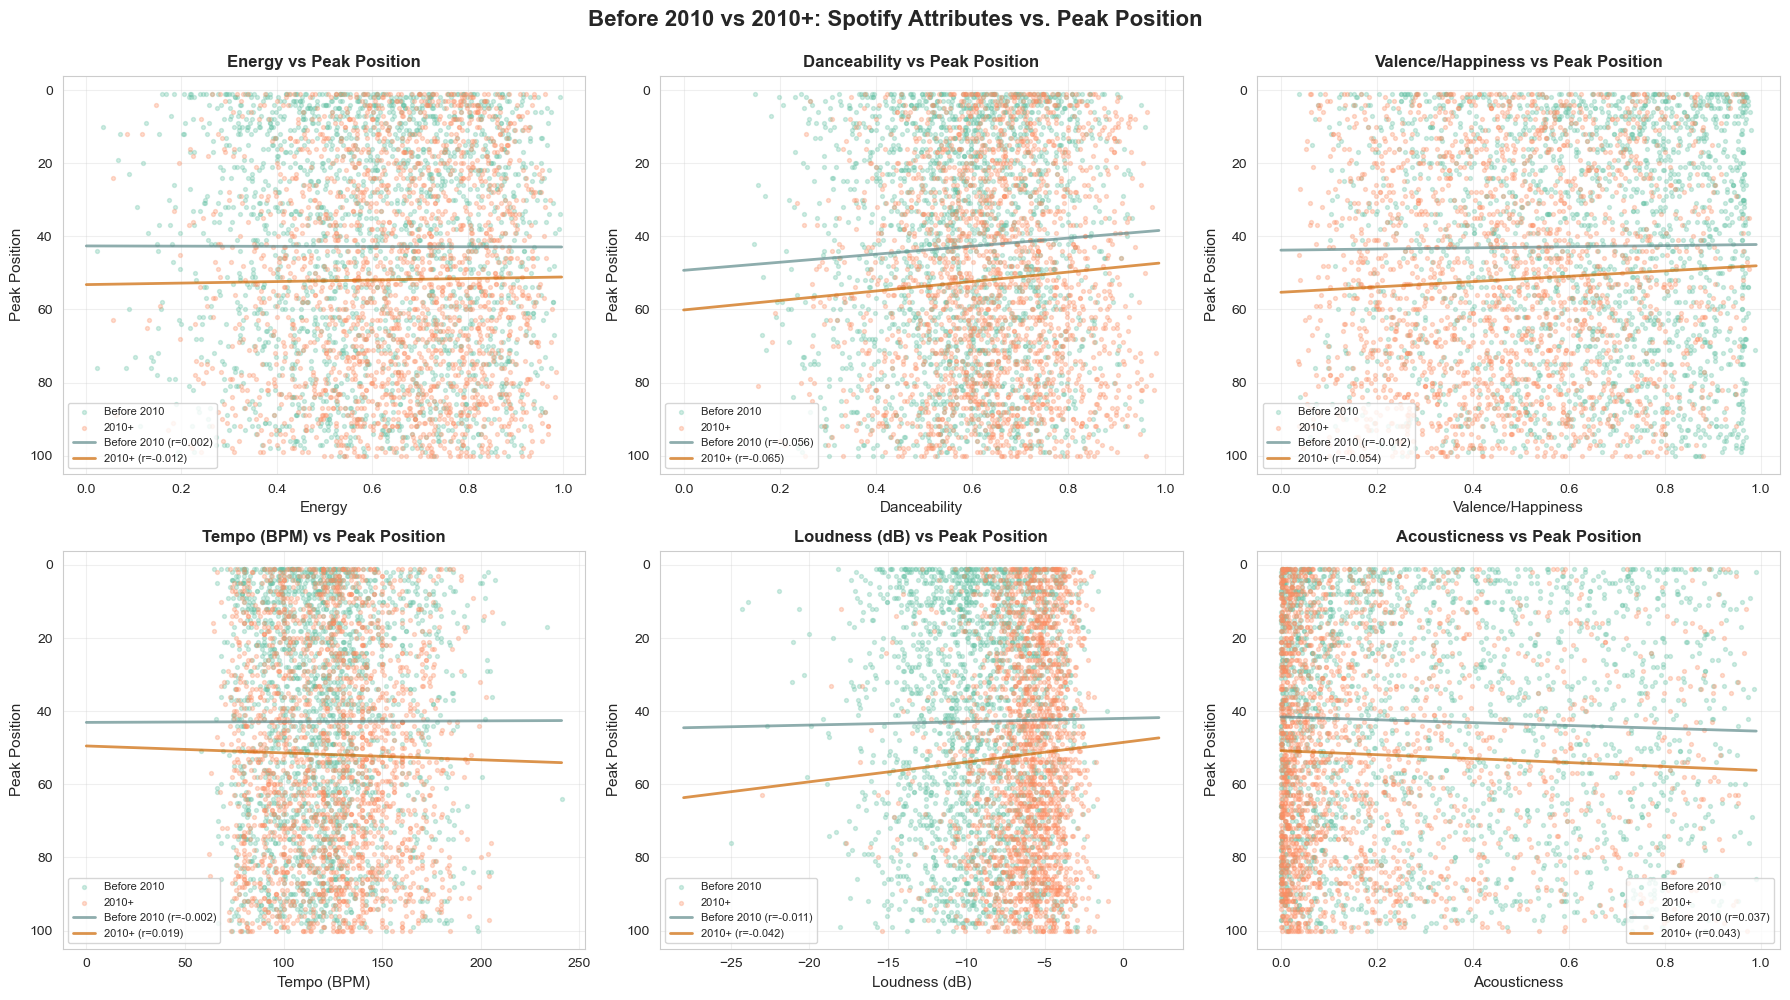

In [11]:
from scipy import stats

# Prepare data
audio_success = billboard.merge(audio_features, on='song_id', how='inner')
audio_success['year'] = pd.to_datetime(audio_success['week_id']).dt.year
audio_success['decade'] = (audio_success['year'] // 10) * 10

song_audio_peak = audio_success.groupby('song_id').agg({
    'peak_position': 'min',
    'energy': 'first',
    'danceability': 'first',
    'valence': 'first',
    'tempo': 'first',
    'loudness': 'first',
    'acousticness': 'first',
    'decade': 'first',
    'song_x': 'first',
    'performer_x': 'first'
}).reset_index()

# All features Before 2010 vs 2010+
song_audio_peak['streaming_era'] = song_audio_peak['decade'].apply(
    lambda x: 'Before 2010' if x < 2010 else '2010+'
)

features = ['energy', 'danceability', 'valence',
            'tempo', 'loudness', 'acousticness']
feature_labels = {
    'energy': 'Energy',
    'danceability': 'Danceability',
    'valence': 'Valence/Happiness',
    'tempo': 'Tempo (BPM)',
    'loudness': 'Loudness (dB)',
    'acousticness': 'Acousticness'
}

# Figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

print("Correlation Comparison - Before 2010 vs 2010+:")
print(f"{'Feature':<15s} {'Before 2010':<15s} {'2010+':<15s} {'Change':<10s}")
print("-" * 60)

for idx, feature in enumerate(features):
  # Get data for both eras and DROP NaN values
  pre_data = song_audio_peak[song_audio_peak['streaming_era'] == 'Before 2010']
  pre_data = pre_data[[feature, 'peak_position']].dropna()

  post_data = song_audio_peak[song_audio_peak['streaming_era'] == '2010+']
  post_data = post_data[[feature, 'peak_position']].dropna()

  # Sample data for plotting (reduce overplotting)
  pre_sample = pre_data.sample(n=min(2000, len(pre_data)), random_state=42)
  post_sample = post_data.sample(n=min(2000, len(post_data)), random_state=42)

  # Plot Before 2010 scatter
  axes[idx].scatter(pre_sample[feature], pre_sample['peak_position'],
                    alpha=0.3, s=8, color=COLORS['before_2010'], label='Before 2010')

  # Plot 2010+ scatter
  axes[idx].scatter(post_sample[feature], post_sample['peak_position'],
                    alpha=0.3, s=8, color=COLORS['after_2010'], label='2010+')

  # Calculate regression for both eras using ALL data (after dropping NaN)
  slope_pre, intercept_pre, r_pre, _, _ = stats.linregress(
      pre_data[feature], pre_data['peak_position'])
  slope_post, intercept_post, r_post, _, _ = stats.linregress(
      post_data[feature], post_data['peak_position'])

  # Create x values for lines
  x_min = min(pre_data[feature].min(), post_data[feature].min())
  x_max = max(pre_data[feature].max(), post_data[feature].max())
  x_line = np.linspace(x_min, x_max, 100)

  # Plot regression lines
  axes[idx].plot(x_line, slope_pre * x_line + intercept_pre,
                 color=COLORS['line_dark1'], linewidth=2, linestyle='-', alpha=0.7,
                 label=f'Before 2010 (r={r_pre:.3f})')

  axes[idx].plot(x_line, slope_post * x_line + intercept_post,
                 color=COLORS['line_dark2'], linewidth=2, linestyle='-', alpha=0.7,
                 label=f'2010+ (r={r_post:.3f})')

  # Labels + formatting
  axes[idx].set_xlabel(feature_labels[feature], fontsize=11)
  axes[idx].set_ylabel('Peak Position', fontsize=11)
  axes[idx].set_title(
      f'{feature_labels[feature]} vs Peak Position', fontsize=12, fontweight='bold')
  axes[idx].invert_yaxis()
  axes[idx].legend(fontsize=8, loc='best')
  axes[idx].grid(True, alpha=0.3)

  # Print correlation comparison
  change = r_post - r_pre
  print(f"{feature:<15s} {r_pre:6.3f}          {r_post:6.3f}          {change:+6.3f}")

# Labels
fig.suptitle('Before 2010 vs 2010+: Spotify Attributes vs. Peak Position',
             fontsize=16, fontweight='bold', y=0.995)

# Display
plt.tight_layout()
plt.show()

#### Peak Chart Position vs. Total Weeks on Chart

The interactive scatter plot shows the correlation between a songs peak chart position and it's chart longevity. Hovering reveals specific songs, making outliers explorable. The x-axis reversal (lower = better) matches intuitive chart position numbering.

There is a clear negative correlation betwen peak position and total weeks on chart. Songs that reach higher peak positions (lower numbers, closer to #1) stay on charts significantly longer.

**The Pattern:**

- **#1 Songs:** The tallest bars on the right show chart-toppers often stay 40-70+ weeks, with some exceptional cases exceeding 80 weeks.
- **Top 20 Songs:** Moderate longevity, typically 20-40 weeks.
- **Lower Positions (#50-100):** The shortest bars on the left show these songs typically chart for just 5-20 weeks before dropping off.

Chart success breeds more chart success. Songs that peak higher gain momentum through increased radio play, playlist placement, media attention, and word-of-mouth, creating a self-reinforcing cycle. Meanwhile, songs that never break into the top tier can fade quickly. Some songs (the scattered points above the bars) defy the pattern, reaching only moderate peak positions but maintaining long chart runs, or vice versa. These might be sleeper hits with dedicated fanbases or viral moments that didn't translate to peak position.

Peak position is one of the strongest predictors of chart longevity we've examined, far more predictive than any audio feature (energy, danceability, etc.). Where a song peaks matters enormously for how long it stays relevant.


In [12]:
import plotly.express as px

# Prepare data
song_summary = billboard.groupby('song_id').agg({
    'weeks_on_chart': 'max',
    'peak_position': 'min',
    'song': 'first',
    'performer': 'first'
}).reset_index()

# Figure
fig = px.scatter(song_summary,
                 x='peak_position',
                 y='weeks_on_chart',
                 hover_data={'song': True,
                             'performer': True,
                             'peak_position': True,
                             'weeks_on_chart': True},
                 trendline='ols',
                 title='Peak Chart Position vs. Total Weeks on Chart',
                 labels={'peak_position': 'Peak Chart Position (lower = better)',
                         'weeks_on_chart': 'Total Weeks on Chart'},
                 opacity=0.5,
                 color_discrete_sequence=[PLOTLY_SET2[0]])

# Hover
fig.update_traces(
    hovertemplate='<b>%{customdata[0]}</b><br>' +
                  'Artist: %{customdata[1]}<br>' +
                  'Peak Position: %{x}<br>' +
                  'Weeks on Chart: %{y}<br>' +
                  '<extra></extra>',
    marker=dict(size=6)
)

# Display
fig.update_xaxes(autorange='reversed')

fig.update_layout(
    height=600,
    font=dict(size=11),
    hovermode='closest'
)

fig.show()

### 4. Chart Dominators

See what songs and artists have dominated the Billboard Hot 100 by time period as well as the highest performers overall.


#### Multi-Panel Stacked Area: Chart Dominance Across Decades

Stacked area charts show both individual artist trajectories (each colored band) and collective dominance (total height) over time. The multi-panel layout allows decade-to-decade comparison while keeping each era's competitive dynamics clear. Color-coding performers makes it easy to track individual rises and falls.

Each decade had clear chart leaders who captured disproportionate market share. The top 5 performers in each era typically controlled 4-8% of all chart weeks, a significant concentration given the thousands of artists competing.

**Generational Shifts:**

- **1950s-1960s:** Early rock pioneers (Elvis, Beatles) achieved unprecedented dominance, with The Beatles' green area consuming up to 7% of all chart weeks in the mid-1960s.
- **1970s-1980s:** More distributed success across disco, rock, and pop icons. No single artist achieved Beatles-level dominance.
- **1990s-2000s:** Pop and hip-hop stars (Madonna, Mariah Carey, TLC) maintained steady presence, with occasional surges during album cycles.
- **2010s:** Volatile patterns with artists like Taylor Swift and Drake experiencing dramatic peaks and valleys, reflecting the streaming era's boom-and-bust cycles.
- **2020s:** Due to the lack of data, this decade's pattern and trend are ongoing and will continue to develop with time.

Chart dominance is era-specific, you can't directly compare The Beatles' 1960s reign to Drake's 2010s success because the competitive landscape, market size, and consumption methods differ fundamentally. However, within each era, top performers consistently capture 4-8% market share, suggesting a consistent pattern of concentration regardless of technology.


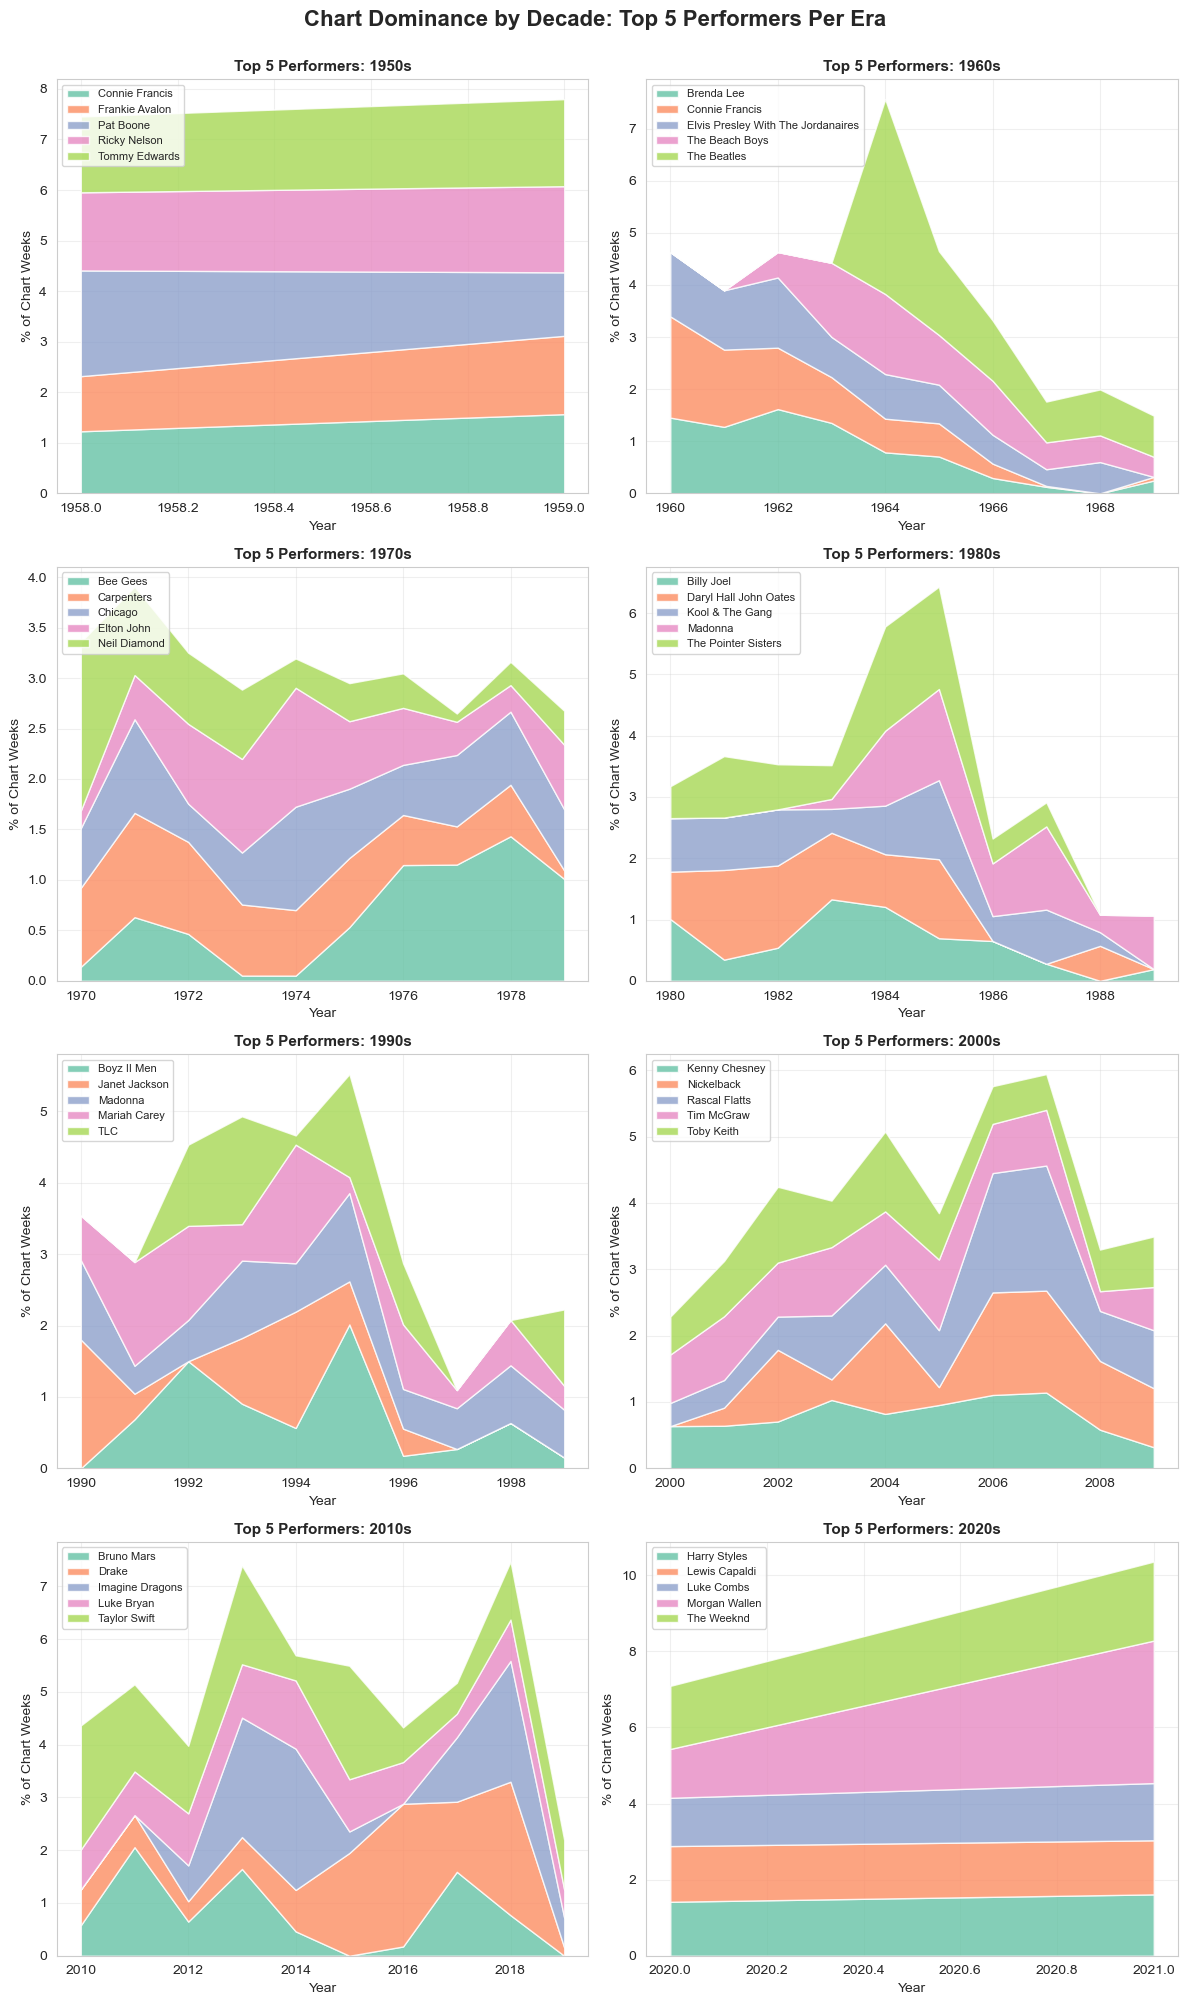

In [13]:
import matplotlib.pyplot as plt

# Prepare data
billboard['year'] = pd.to_datetime(billboard['week_id']).dt.year
billboard['decade'] = (billboard['year'] // 10) * 10
billboard['decade_label'] = billboard['decade'].astype(str) + 's'

decades = sorted(billboard['decade'].unique())

# Figure
n_decades = len(decades)
n_cols = 2
n_rows = (n_decades + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()

for idx, decade in enumerate(decades):
  decade_data = billboard[billboard['decade'] == decade]

  # Calculate weeks per performer in this decade
  decade_presence = decade_data.groupby(['performer', 'year', 'song_id']).agg({
      'weeks_on_chart': 'max'
  }).reset_index()

  performer_by_year = decade_presence.groupby(['performer', 'year'])[
      'weeks_on_chart'].sum().reset_index()

  # Get total weeks per year
  total_by_year = performer_by_year.groupby(
      'year')['weeks_on_chart'].sum().reset_index()
  total_by_year.columns = ['year', 'total_all_weeks']

  # Get top 5 performers for THIS decade
  decade_totals = performer_by_year.groupby(
      'performer')['weeks_on_chart'].sum().reset_index()
  top_5_decade = decade_totals.nlargest(5, 'weeks_on_chart')[
      'performer'].tolist()

  # Calculate market share
  top_performers_data = performer_by_year[performer_by_year['performer'].isin(
      top_5_decade)]
  top_by_year = top_performers_data.pivot(
      index='year', columns='performer', values='weeks_on_chart').fillna(0)
  top_by_year = top_by_year.merge(
      total_by_year, left_index=True, right_on='year')
  top_by_year.set_index('year', inplace=True)

  # Calculate percentages
  for performer in top_5_decade:
    if performer in top_by_year.columns:
      top_by_year[performer] = (
          top_by_year[performer] / top_by_year['total_all_weeks']) * 100

  top_by_year = top_by_year.drop('total_all_weeks', axis=1)

  # Plot stacked area for this decade
  axes[idx].stackplot(top_by_year.index,
                      *[top_by_year[col] for col in top_by_year.columns],
                      labels=top_by_year.columns,
                      alpha=0.8)

  axes[idx].set_xlabel('Year', fontsize=10)
  axes[idx].set_ylabel('% of Chart Weeks', fontsize=10)
  axes[idx].set_title(
      f'Top 5 Performers: {decade}s', fontsize=11, fontweight='bold')
  axes[idx].legend(loc='upper left', fontsize=8)
  axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(decades), len(axes)):
  axes[idx].set_visible(False)

# Display
fig.suptitle('Chart Dominance by Decade: Top 5 Performers Per Era',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

#### Interactive Bar Chart: Most Prolific Chart Performers

Interactive horizontal bars with color gradient make rankings immediately clear while allowing exploration of specific values. The gradient from dark (high) to light (low) reinforces the hierarchy visually.

Glee Cast dominates with ~185 chart hits - nearly 50% more than second place. This reflects the show's weekly single releases covering popular songs, creating an unprecedented chart presence through a unique business model rather than traditional artist output. It's worth noting that although this group holds the highest number of hits, the difference of number of weeks charted between itself and the other tops artists is stark (Glee Cast: 223, Taylor Swift: 1022, Drake: 746, ...). This information can be found by hovering over each bar.

**Modern vs Classic Prolificacy:**
The interactive nature reveals specific counts, notice how modern artists leverage streaming (every album track can chart) while classic acts relied on strategic single releases.

- **Contemporary artists** (Taylor Swift, Drake) chart 100-130 songs, benefiting from streaming's playlist culture and album tracks charting individually
- **Legacy artists** (Beatles, Elvis, Rolling Stones) achieved 50-70 hits during eras when only singles charted, important aspects to consider when making comparisons between artists from different landscapes

The gap between number of hits narrows significantly after the top 3. Most performers in positions 4-20 cluster around 50-60 hits, suggesting a natural ceiling for sustained chart presence across career spans.

Raw hit count doesn't tell the full story. Glee Cast's volume reflects a TV show's production model, not individual artistry. Comparing Drake's 100 hits (in the streaming era where albums chart entirely) to The Beatles' 67 (when only promoted singles charted) requires era-adjusted interpretation.


In [14]:
import plotly.express as px

# Prepare data
num_hits_per_performer = billboard.groupby(
    'performer')['song_id'].nunique().reset_index()
num_hits_per_performer.columns = ['performer', 'num_hits']

# Calculate total weeks for hover info
song_weeks = billboard.groupby(['performer', 'song_id']).agg({
    'weeks_on_chart': 'max'
}).reset_index()
total_weeks_per_performer = song_weeks.groupby(
    'performer')['weeks_on_chart'].sum().reset_index()
total_weeks_per_performer.columns = ['performer', 'total_weeks']

# Merge the two metrics
performer_stats = num_hits_per_performer.merge(
    total_weeks_per_performer, on='performer')

# Get top 20 performers by number of hits
top_performers_hits = performer_stats.nlargest(
    20, 'num_hits').sort_values('num_hits')


# Figure
fig = px.bar(top_performers_hits,
             y='performer',
             x='num_hits',
             orientation='h',
             title='Top 20 Performers by Number of Chart Hits',
             labels={'num_hits': 'Number of Chart Hits',
                     'performer': 'Performer'},
             hover_data={'num_hits': True,
                         'total_weeks': True, 'performer': False},
             color='num_hits',
             color_continuous_scale='OrRd')

# Hover
fig.update_traces(
    hovertemplate='<b>%{y}</b><br>' +
                  'Number of Hits: %{x}<br>' +
                  'Total Weeks on Chart: %{customdata[0]}<br>' +
                  '<extra></extra>'
)

# Display
fig.update_layout(
    height=700,
    xaxis_title='Number of Chart Hits',
    yaxis_title='',
    showlegend=False,
    font=dict(size=11)
)

fig.show()

#### Interactive Bar Chart: Cumulative Chart Impact

The color gradient (dark teal = more weeks) makes Taylor Swift's exceptional dominance immediately apparent. Interactive hover reveals exact week counts, and the horizontal layout accommodates long artist names easily.

Taylor Swift leads with over 1,000 total weeks on chart - the equivalent of nearly 20 years of continuous presence. This measures sustained impact rather than just hit quantity.

**Quality Over Quantity:** Comparing the two charts reveals interesting discrepancies:

- Glee Cast: #1 in hits (185) but absent from top 20 in total weeks - many brief appearances
- Taylor Swift: #2 in hits (130) but #1 in total weeks (1,000+) - songs that endure
- Elton John: Not in top quantity but #2 here (~950 weeks) - hits that stay relevant for decades

**Different Eras, Different Metrics:**

- **Classic artists** (Beatles, Rolling Stones, Elton John) accumulated weeks across decades of catalog staying power
- **Modern artists** (Drake, Taylor Swift) leverage streaming's long tail - songs remain accessible and continue charting years after release

Artists like Madonna, Mariah Carey, and Michael Jackson (~700-800 weeks) represent the pre-streaming sweet spot - enough hits to accumulate weeks, released when chart longevity required radio/sales persistence.

Total weeks measures true cultural staying power. It rewards both prolific output AND songs that resonate long-term. This metric arguably better captures "chart dominance" than hit count alone - it's not just about showing up, but about staying relevant.


In [15]:
import plotly.express as px
import plotly.graph_objects as go

# Prepare data
song_weeks = billboard.groupby(['performer', 'song_id']).agg({
    'weeks_on_chart': 'max'
}).reset_index()

performer_stats = song_weeks.groupby('performer').agg({
    'weeks_on_chart': 'sum',
    'song_id': 'nunique'
}).reset_index()
performer_stats.columns = ['performer', 'total_weeks', 'num_songs']

top_performers = performer_stats.nlargest(
    20, 'total_weeks').sort_values('total_weeks')

# Figure
fig = px.bar(top_performers,
             y='performer',
             x='total_weeks',
             orientation='h',
             title='Top 20 Performers by Total Weeks on Chart',
             labels={'total_weeks': 'Total Weeks on Chart',
                     'performer': 'Performer'},
             hover_data={'total_weeks': True,
                         'num_songs': True, 'performer': False},
             color='total_weeks',
             color_continuous_scale='Tealgrn')

# Hover
fig.update_traces(
    hovertemplate='<b>%{y}</b><br>' +
                  'Total Weeks: %{x}<br>' +
                  'Number of Songs: %{customdata[0]}<br>' +
                  '<extra></extra>'
)

# Display
fig.update_layout(
    height=700,
    xaxis_title='Total Weeks on Chart',
    yaxis_title='',
    showlegend=False,
    font=dict(size=11)
)

fig.show()

## Conclusions

### Summary of Key Findings

This analysis of over 327,000 Billboard Hot 100 chart entries spanning 1958-2021 reveals how fundamentally the music industry and chart dynamics have transformed, particularly in the streaming era.

#### 1. Chart Success is Highly Unequal

The distribution of chart longevity follows a classic "long tail" pattern, most songs have brief chart runs while a small number of mega-hits achieve extraordinary staying power (80+ weeks). This winner-take-most dynamic has only intensified over time.

#### 2. The Streaming Revolution Change

Around 2010, corresponding with the rise of Spotify, TikTok, and social media, we observe dramatic shifts:

- **"Climber" songs dropped from 75% to 20%** - Songs now debut with immediate impact rather than building gradually
- **Increased polarization** - Modern charts feature both flash-in-the-pan viral hits and unprecedented longevity for mega-hits
- **Songs got 32% shorter** since the 1990s peak, optimized for streaming economics and shrinking attention spans

#### 3. No Simple "Formula" for Success

Despite examining six audio features (energy, danceability, valence, tempo, loudness, acousticness), **none predict chart success** (all |r| < 0.06). This finding holds true in both the pre-2010 and post-2010 eras. Chart performance depends far more on:

- Marketing budgets and promotional strategies
- Artist reputation and existing fanbase
- Cultural timing and zeitgeist alignment
- Viral moments and algorithmic playlist placement
- The intangible "hit quality" that transcends measurable attributes

#### 4. Peak Position Drives Longevity

The strongest relationship we found: songs that peak higher stay on charts significantly longer (r = [correlation]). Chart success creates more success through increased exposure, radio play, and media attention, a self-reinforcing cycle that audio characteristics alone cannot predict.

### Implications

**For Artists:** Success in the modern era requires optimizing for immediate impact, having strong debuts matter more than slow builds. Song length, hooks, and social media virality are critical. However, the lack of an audio "formula" is encouraging as there's no single template to copy. The raw artistry behind music stays somewhat intact.

**For the Industry:** The data suggests streaming platforms and social media have created a more volatile, winner-take-all environment. While democratizing music distribution, these platforms may paradoxically concentrate success among viral phenomena.

**For Researchers:** The weak correlation between audio features and chart success suggests that cultural, social, and marketing factors dominate musical ones. Future research should incorporate social media metrics, marketing spend, and network effects.

### Limitations

1. **Incomplete Audio Data:** Only 9% of Billboard songs have Spotify audio features, potentially biasing analyses toward modern, Spotify-available music
2. **Billboard Methodology Changes:** Chart calculation methods have evolved (sales → radio → streaming), making cross-era comparisons imperfect
3. **Causality vs Correlation:** We observe relationships but cannot prove causation - does high energy cause success, or do successful songs happen to be high energy?
4. **Missing Variables:** We lack data on marketing budgets, social media engagement, radio play intensity, and other likely success drivers
5. **Survivorship Bias:** Songs that never charted don't appear in our dataset, limiting insights about what prevents chart entry

### Final Thought

The transformation from gradual "climbers" building momentum through radio play to instant viral sensations reflects not just technological change, but a fundamental restructuring of how culture spreads. In the streaming era, music discovery is algorithmic and attention is fragmented. Understanding the dynamics of social media algorithms and playlist curators have become crucial for anyone simply aiming for statistical commercial success in the modern music landscape.


## Appendix

### Resources and References

#### Data Sources

- **Kaggle - Top 100 Billboard:** Sujay Kapadnis - https://www.kaggle.com/datasets/sujaykapadnis/top-100-billboard

#### Technical Documentation

- **Python Libraries:**
  - pandas (2.x) - Data manipulation: https://pandas.pydata.org/docs/
  - NumPy (1.x) - Numerical computing: https://numpy.org/doc/
  - Matplotlib (3.x) - Visualization: https://matplotlib.org/stable/contents.html
  - Seaborn (0.x) - Statistical visualization: https://seaborn.pydata.org/
  - Plotly (5.x) - Interactive charts: https://plotly.com/python/
  - SciPy (1.x) - Statistical tests: https://docs.scipy.org/doc/scipy/

#### Additional Reading

- Spotify Audio Features Explained: https://developer.spotify.com/documentation/web-api/reference/get-audio-features
- Billboard Chart Methodology: https://www.billboard.com/charts/

#### Code Repository

- GitHub Repository: https://github.com/IT2053C-Gilany/final-project-smithmaria
- Spotify for API access to audio features

#### Contact

- Maria Smith
- https://github.com/smithmaria
